In [30]:
import os
import re
import glob
import numpy as np
import pickle
import cv2
from matplotlib import pyplot as plt
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model
from keras import metrics
import numpy as np
import os, glob, cv2
from scipy.ndimage import imread
from sklearn.model_selection import train_test_split
import h5py

In [7]:
files = glob.glob('/data/run*-sample*-score*.pkl')
X = []
y = []
for elem in files:
    attrs = elem.split('/')[2].split('.')[0].split('-')
    attrs = [re.findall(r'\d+', x) for x in attrs]
    this_y = [int(x[0]) for x in attrs][2]
    
    f = open(elem, 'rb')
    # unpickling py2 data into py3 requires latin1 encoding
    this_X = pickle.load(f, encoding='latin1')
    f.close()
    if this_X.shape == (129, 223):
        this_X = cv2.copyMakeBorder(this_X, 0, 95, 1, 0, cv2.BORDER_CONSTANT,value=0)
        this_X = cv2.cvtColor(this_X,cv2.COLOR_GRAY2RGB)
        X.append(this_X)
        y.append(this_y)

X = np.stack(X)
y = np.array(y)

In [11]:
print(np.unique(y, return_counts=True))
print(np.unique(y, return_counts=True)[1][0], np.sum(np.unique(y, return_counts=True)[1][1:]))

(array([0, 1, 2, 3, 4, 5]), array([228,  48,  41,  55,  83,  69]))
228 296


In [12]:
binary_y = []
for elem in y:
    if elem == 0:
        binary_y.append([1, 0]) # one-hot encoded 0
    else:
        binary_y.append([0, 1])
binary_y = np.stack(binary_y)

In [50]:
X_train, X_test, binary_y_train, binary_y_test = train_test_split(X, binary_y)

In [14]:
X_train.shape, X_test.shape, binary_y_train.shape, binary_y_test.shape

((393, 224, 224, 3), (131, 224, 224, 3), (393, 2), (131, 2))

Score: 5


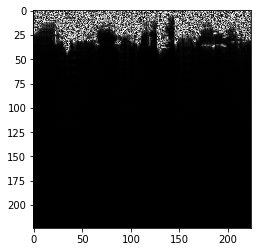

In [23]:
n = 5
plt.imshow(X[n])
print('Score: %s' % y[n])
plt.show()

Score: 1


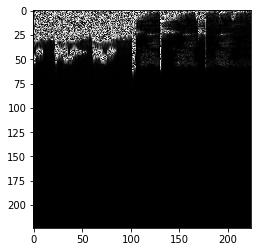

In [20]:
n = 4
plt.imshow(X[n])
print('Score: %s' % y[n])
plt.show()

Score: 2


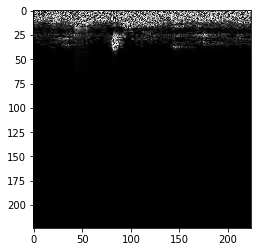

In [24]:
n = 21
plt.imshow(X[n])
print('Score: %s' % y[n])
plt.show()

In [51]:
model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()
for layer in model_vgg16_conv.layers:
    layer.trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [52]:
input = Input(shape=(224,224,3),name = 'image_input')
output_vgg16_conv = model_vgg16_conv(input)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(20, activation='relu', name='fc')(x)
x = Dense(2, activation='softmax', name='predictions')(x)
model = Model(input=input, output=x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, binary_y_train, epochs=40)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("pr...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                multiple                  14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc (Dense)                   (None, 20)                501780    
_________________________________________________________________
predictions (Dense)          (None, 2)                 42        
Total params: 15,216,510
Trainable params: 501,822
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
393/393 [==============================] - 6s - loss: 0.9344 - acc: 0.8066     
Epoch 2/100
393/393 [===========

393/393 [==============================] - 6s - loss: 0.1717 - acc: 0.9898     
Epoch 78/100
393/393 [==============================] - 6s - loss: 0.1705 - acc: 0.9898     
Epoch 79/100
393/393 [==============================] - 6s - loss: 0.1703 - acc: 0.9898     
Epoch 80/100
393/393 [==============================] - 6s - loss: 0.1701 - acc: 0.9898     
Epoch 81/100
393/393 [==============================] - 6s - loss: 0.1701 - acc: 0.9898     
Epoch 82/100
393/393 [==============================] - 6s - loss: 0.1700 - acc: 0.9898     
Epoch 83/100
393/393 [==============================] - 6s - loss: 0.1699 - acc: 0.9898     
Epoch 84/100
393/393 [==============================] - 6s - loss: 0.1699 - acc: 0.9898     
Epoch 85/100
393/393 [==============================] - 6s - loss: 0.1699 - acc: 0.9898     
Epoch 86/100
393/393 [==============================] - 6s - loss: 0.1698 - acc: 0.9898     
Epoch 87/100
393/393 [==============================] - 6s - loss: 0.1697 - acc: 0.

In [56]:
model.save('speech-detection.h5')

In [53]:
binary_y_pred = [np.argmax(elem) for elem in model.predict(X_test)]
binary_y_true = [np.argmax(elem) for elem in binary_y_test]

In [54]:
is_accurate = [binary_y_pred[i] == binary_y_true[i] for i in range(len(binary_y_pred))]

In [55]:
np.unique(is_accurate, return_counts=True)

(array([False,  True], dtype=bool), array([  8, 123]))